# E-03. Cat-whiskers Sticker app

## 1. 정면 사진(test)

### 스티커와 이미지 준비하기

스티커: [고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)<br>

이미지: 셀카 (+ 추후에 모델 평가를 위해 다양한 종류의 연예인, 운동선수 사진을 추가하였다.)


### 필요한 라이브러리 import

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

### 이미지 불러오기 

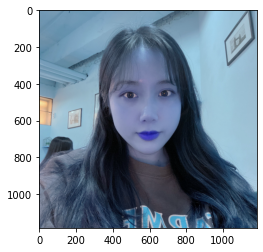

In [46]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.png'
img_bgr = cv2.imread(my_image_path)

#img_bgr = cv2.resize(img_bgr, (640, 480))
img_show = img_bgr.copy() # 출력용 이미지

plt.imshow(img_bgr)
plt.show()

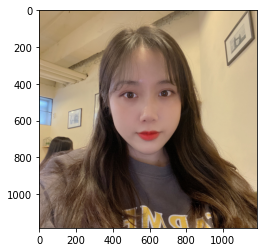

In [47]:
# RGB 출력
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 얼굴 검출 & 랜드마크 검출 하기

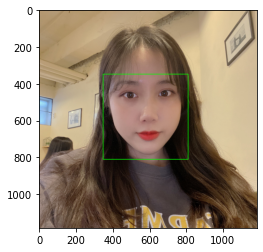

In [48]:
# 얼굴 위치 찾기(object detection)
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
dlib_rects = detector_hog(img_rgb,1) 

# dilib-rect 가 얼굴을 찾는 4각형
for dlib_rect in dlib_rects:
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)

### 스티커 적용 위치 확인하기

68


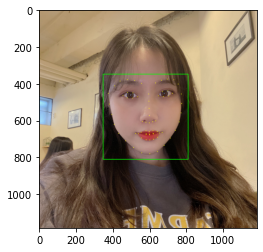

In [49]:
# face landmark
# 저장한 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark 수 확인
print(len(list_landmarks[0])) 

# 사진에 랜드마크 나타내기
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기
일반적으로 코의 위치로 x, y값을 설정하면 알맞게 들어맞는다고 들었지만, 직접해보니 인중과 코의 중간 위치로 해야 수염이 예쁘게 들어맞어 맞는 것 같아서 위치를 조정해봤다.

In [55]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = (landmark[30][1]+landmark[33][1])//2
    
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(600, 573)
(x,y) : (600,593)
(w,h) : (463,463)


In [56]:
# 스티커 이미지 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

In [57]:
# 스티커 이미지 좌표
refined_x = x - w // 2 # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


(x,y) : (369,362)


- 코에 스티커를 붙이는 것이라 이미지의 영역을 크게 벗어날 일이 없을 것 같긴 하지만, 다른 스티커를 대체로 붙였을 경우를 생각하여 추가하였다.

In [58]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

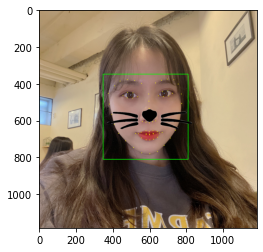

In [59]:
# 고양이 수염 합치기
# 배열에 대한 슬라이싱할 때 행(y)부터 쓰고 열(x)을 쓴다.
# 스티커를 붙일 공간을 정한다.
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker ==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 최종 결과 출력하기
바운딩 박스와 랜드마크를 제거하였다.
원하는 위치에 스티커가 잘 출력된 것을 확인할 수 있다.

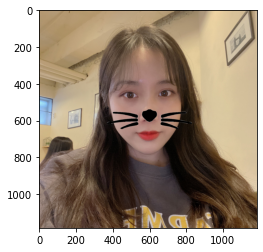

In [60]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 다양한 이미지들에 비교해보기 위한 클래스 생성
다양한 제약이 있는 이미지들에 해당 모델을 간편하게 비교할 수 있도록 클래스를 생성한다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib


# 이미지 불러오기
my_image_path2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
my_image_path3 = os.getenv('HOME')+'/aiffel/camera_sticker/images/측면.png'
my_image_path4 = os.getenv('HOME')+'/aiffel/camera_sticker/images/눕혀진.png'
my_image_path5 = os.getenv('HOME')+'/aiffel/camera_sticker/images/먼거리.png'
my_image_path6 = os.getenv('HOME')+'/aiffel/camera_sticker/images/안경.png'
my_image_path7 = os.getenv('HOME')+'/aiffel/camera_sticker/images/가림.png'
my_image_path8 = os.getenv('HOME')+'/aiffel/camera_sticker/images/마스크.png'
my_image_path9 = os.getenv('HOME')+'/aiffel/camera_sticker/images/어두운.png'
my_image_path10 = os.getenv('HOME')+'/aiffel/camera_sticker/images/단체.png'


# 저장한 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# 스티커 이미지 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'

class StickerApp:
    # 얼굴 위치 찾기(object detection)
    detector_hog = dlib.get_frontal_face_detector()
    
    def __init__(self, image_path, model_path, sticker_path):
        self.detector_hog = dlib.get_frontal_face_detector()
        self.img_bgr = cv2.imread(image_path) 
        self.img_show = self.img_bgr.copy() # 출력용 이미지
        self.img_rgb = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB) #RGB 이미지
        self.dlib_rects = self.detector_hog(self.img_rgb,1) 
        self.landmark_predictor = dlib.shape_predictor(model_path)
        self.list_landmarks = [] 
        self.img_sticker = cv2.imread(sticker_path)


    def original_image(self):
        plt.imshow(self.img_rgb)
        plt.show()
        
    def face_rectangle(self):
        for dlib_rect in self.dlib_rects:
            l = dlib_rect.left() 
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(self.img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        
        img_show_rgb = cv2.cvtColor(self.img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb)
        plt.show()        

    # 랜드마크 찾기
    def show_landmarks(self):       
        for dlib_rect in self.dlib_rects:
            points = self.landmark_predictor(self.img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            self.list_landmarks.append(list_points)

            for landmark in self.list_landmarks:
                for idx, point in enumerate(list_points):
                    cv2.circle(self.img_show, point, 2, (0, 255, 255), -1)
            
        img_show_rgb2 = cv2.cvtColor(self.img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb2)
        plt.show()            
            
    def put_sticker(self):
        for dlib_rect, landmark in zip(self.dlib_rects, self.list_landmarks):
            global x, y, w, h
            # nose center index : 30
            x = landmark[30][0]
            y = (landmark[30][1]+landmark[33][1])//2

            # 얼굴의 폭, 높이
            w = dlib_rect.width()
            h = dlib_rect.width()

        self.img_sticker = cv2.resize(self.img_sticker, (w, h))
        
        # 스티커 이미지 좌표
        refined_x = x - w // 2 # left
        refined_y = y - h // 2  # top

        # y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
        if refined_y < 0:
            self.img_sticker = self.img_sticker[-refined_y:]
            refined_y = 0
            
        sticker_area = self.img_bgr[refined_y:refined_y + self.img_sticker.shape[0], refined_x:refined_x+self.img_sticker.shape[1]]
        self.img_bgr[refined_y:refined_y + self.img_sticker.shape[0], refined_x:refined_x+self.img_sticker.shape[1]] = \
            np.where(self.img_sticker==255,sticker_area,self.img_sticker).astype(np.uint8)

        plt.imshow(cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()

## 2. 다양한 이미지에서의 적용

### 측면 사진 (정면에서 약간 틀어짐)
정면에서 약간 틀어진 측면 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에는 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 잘 출력 되었다.

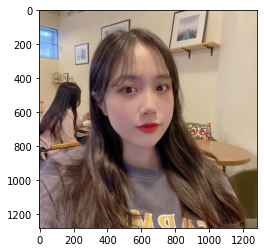

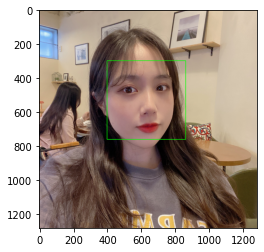

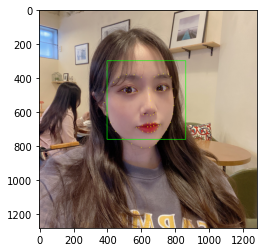

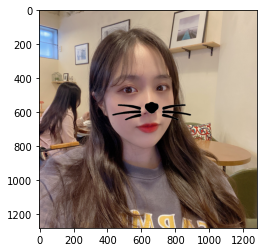

In [2]:
new_image = StickerApp(my_image_path2, model_path, sticker_path)
new_image.original_image()
new_image.face_rectangle()
new_image.show_landmarks()
new_image.put_sticker()

### 측면 (정면에서 많이 틀어짐)
우측으로 고개를 많이 돌린 측면 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에서도 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 잘 출력 되었다.

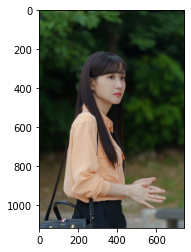

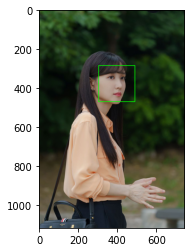

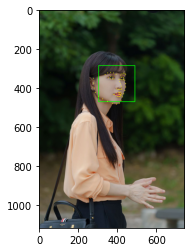

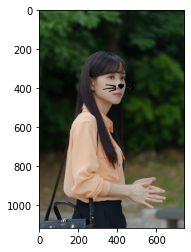

In [3]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기
new_image = StickerApp(my_image_path3, model_path, sticker_path) 
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 얼굴이 누워져있는 사진
얼굴이 누워져 있는 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에서는 얼굴 인식과 랜드 마크가 되지 않은 것을 확인할 수 있다.<br>
당연히 얼굴 인식에 실패하였으므로, 스티커 또한 출력하지 못 하였다.

face detector가 누워있는 사진은 인식하지 못하는 특성으로 인한 것으로 생각 된다.

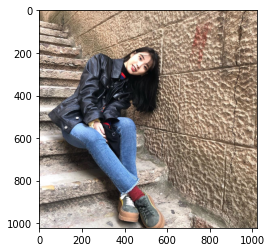

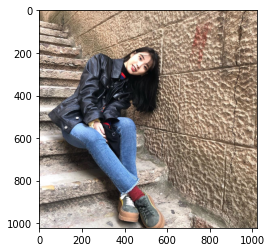

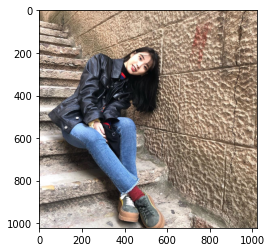

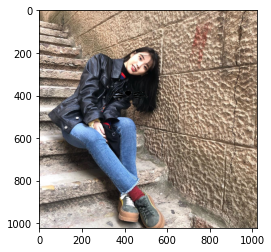

In [4]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path4, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 멀리 있는 얼굴
얼굴이 멀리 위치한 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에서는 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 잘 출력 되었다.

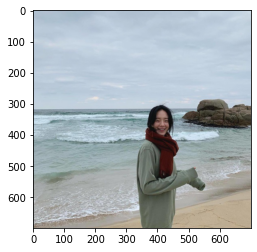

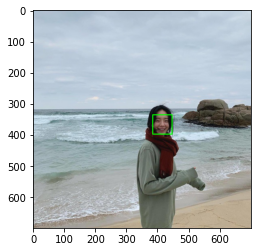

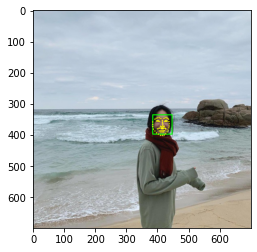

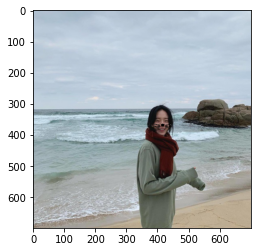

In [5]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기
new_image = StickerApp(my_image_path5, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 안경 쓴 얼굴
안경을 쓴 얼굴 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에는 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 원하는 위치에 출력 되었다.

하지만 얼굴이 좌우로 기울어짐에 따른 스티커의 각도 변화를 별도로 설정해주지 않았기 때문에 스티커는 얼굴의 각도와는 다르게 고정되어 있음을 확인할 수 있다.

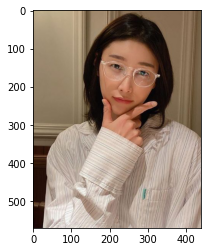

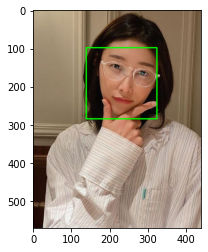

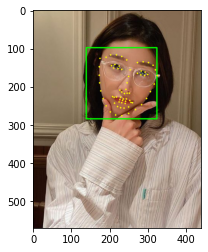

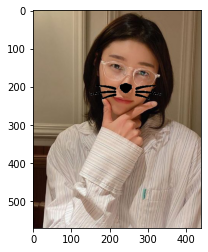

In [6]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path6, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 얼굴이 가려진 사진(좌우 기준)
좌측 얼굴이 가려진 사진을 통해 스티커가 잘 출력되는지 확인해보았다.<br>
얼굴의 일부가 가려짐에도 불구하고 얼굴 인식된 것을 확인할 수 있다.<br>
그에 따라 스티커도 출력 되었다.

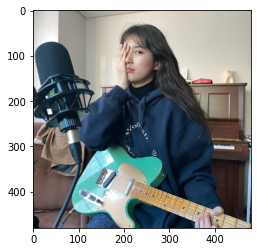

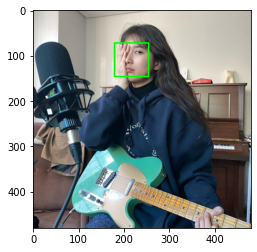

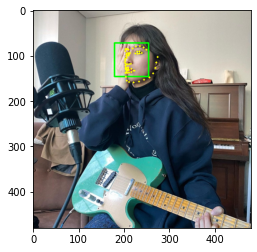

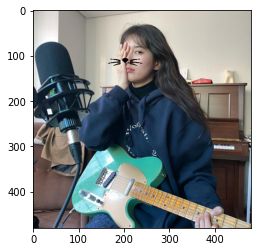

In [7]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path7, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 얼굴이 가려진 사진(상하 기준)
얼굴의 하부가 마스크로 인해 가려진 사진에서 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에는 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 잘 출력 되었다.

그러나 마찬가지로 얼굴 각도에 대한 별도 설정을 해주지 않았기 때문에 얼굴 각도와 스티커의 각도가 달라 이질감이 드는 문제가 있다.

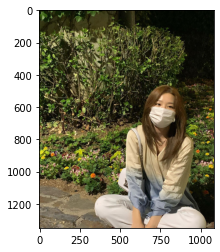

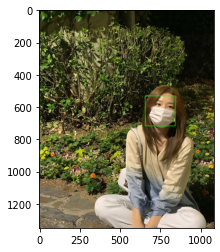

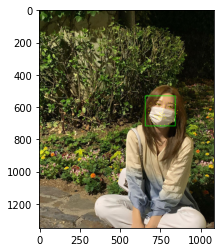

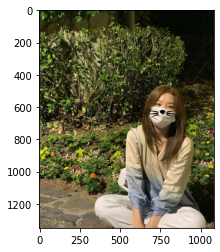

In [8]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path8, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 밝기가 어두운 사진

밝기가 어두운 사진에서 스티커가 잘 출력되는지 확인해보았다.<br>
해당 사진에는 얼굴 인식과 랜드 마크가 적절한 위치에 잘 된 것을 확인 할 수 있다.<br>
그에 따라 스티커도 잘 출력 되었다.

하지만 스티커 주변이 흰색으로 지저분한 것을 볼 수 있다.
이 또한 문제점으로 볼 수 있을 것 같다.

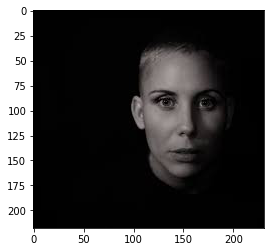

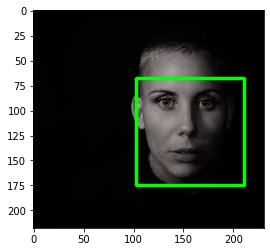

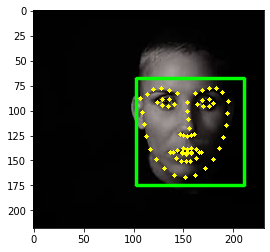

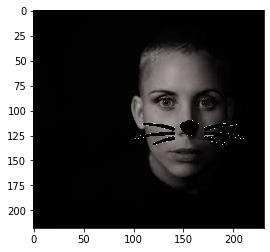

In [9]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path9, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

### 단체 사진 (다수의 얼굴)
다수의 얼굴이 함께 나온 사진에서 스티커가 잘 출력되는지 확인해보았다.<br>
얼굴 인식과 랜드마크는 모든 얼굴에서 잘 되었으나 스티커가 한 명에만 한정되어 나타나는 것을 확인 할 수 있다.<br>

모든 얼굴에 스티커를 붙여보고자 반복적인 시도를 해보았으나, 지속적으로 오류가 발생하거나 변화가 없었다.
한 사진에 다수의 얼굴이 있을 때, 모든 얼굴에 스티커가 부착될 수 있도록 모델을 구현할 수 있는 방법을 고민해봐야 할 것 같다.

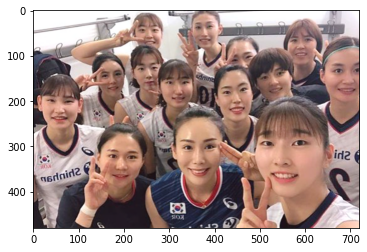

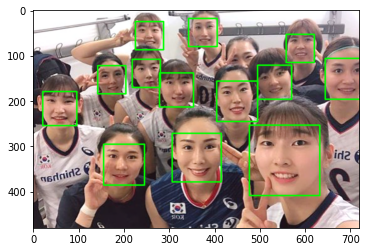

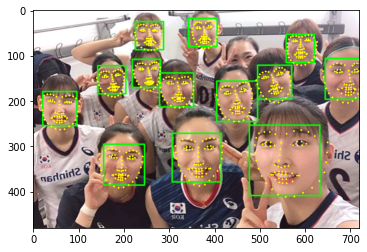

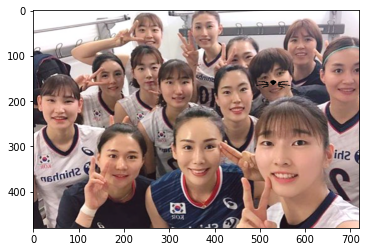

In [10]:
# 1. 원본 이미지
# 2. 얼굴 인식 (바운딩 박스)
# 3. 랜드마크 표시
# 4. 스티커 붙이기

new_image = StickerApp(my_image_path10, model_path, sticker_path)
new_image.original_image() # 1
new_image.face_rectangle() # 2
new_image.show_landmarks() # 3
new_image.put_sticker() # 4

---

## 생각해볼 문제점

#### 얼굴 각도에 따라 스티커가 어떻게 변해야하는가?
얼굴 각도에 따라 스티커의 각도도 함께 변화해야한다. 또한 사이즈도 어느정도 함께 변화해야한다고 생각한다 (가까운 부분과 먼 부분의 크기의 차이).


#### 멀리서 촬영하면 왜 안될까? 옆으로 누워서 촬영하면 왜 안될까?
 기존에 학습한 얼굴과 비교해 가장 유사한 구역을 선택하므로, 거리가 멀거나 옆으로 누워서 촬영하게 될 경우 얼굴의 형태나 gradient가 달라 얼굴을 인식하기 어려울 것이다. 

 얼굴을 인식하기 어렵게 되면 자연스럽게 스티커를 붙이는 것에도 문제가 발생함으로 스티커 앱을 사용하기 위해서는 얼굴을 인식할 수 있는 정도의 거리와 구도를 고려해야할 것 같다.


#### 실행 속도가 중요할까?
 사용자 입장에서 생각하였을 때, 찍혀진 사진에 스티커를 붙이는 시간이 오래걸려도 불편함을 느낄뿐만 아니라, 스티커를 선택 및 변경, 영상 촬영까지 하게 되는 경우 정말 답답하고 불편할 것이다.

 사용하는데 불편함이 느껴지는 서비스는 곧 수요가 줄어들게 되고 공급의 필요성을 상실할 것이다. 만약 해당 서비스를 통해 수익을 창출하는 경우에는 상업성까지 잃게 될 수 있을 것 같다.



#### 스티커앱을 만들 때 정확도가 얼마나 중요한가?
 이 앱의 주요 기능이 얼굴인식을 통해 원하는 스티커를 올바른 위치에 붙이는 것을 제공하는 것이다.
그렇기 때문에 얼굴을 정확하게 인식하는 것이 가장 우선이 된다.
스티커를 인식한 얼굴에 따라 사이즈를 조절하여 정확한 위치에 붙여야 하기 때문에 정확성은 매우 중요하다.

정확도를 잃는다면 이 스티커앱은 메인 기능을 잃는 것과 같고 이는 스티커앱의 가치가 없어진다는 것과 같다고 생각한다.

---

## 평가 및 회고

#### 스티커 합성이 제대로 되었는가?
얼굴이 누워져있는 사진과 단체 사진에서 1명을 제외한 다른 사람들의 얼굴에 스티커를 붙이지 못한 케이스를 제외하고 모두 스티커 합성이 잘 된 것을 볼 수있다.

얼굴 인식 관련 문제를 제외하고, 추가적으로 아쉬운 부분이 있다면 밝기가 어두운 사진에서 스티커의 표면에 흰색으로 나타나는 부분을 처리하지 못한 것이 마음에 걸린다.

프로젝트 제출 기한으로 인해 수정하지 못하고 제출을 하였으나, 이후에 조금 더 수정을 해볼 필요가 있을 것 같다.

#### 정확한 좌표 계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 출력 되었는가?
고양이 수염의 위치가 대부분의 사진에서 알맞은 위치에 잘 출력되었다.

다만, 각도에 관련하여 별도 설정을 해주지 않았기 때문에 얼굴을 좌우로 기울인 사진들에서는 스티커가 얼굴 각도에 맞춰 변화하지 않았다.

그 점이 아쉽긴 하지만, 좌표와 관련한 문제는 없었던 것 같다.



#### 얼굴 각도, 이미지 밝기, 촬영 거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였는가? 
얼굴의 각도 (정면, 측면으로 얼굴을 돌렸을 때, 좌우로 고개를 기울였을 때, 눕혔을 때)와 이미지가 어두울 때, 인식해야할 얼굴이 먼거리에 있을 때, 안경을 쓴 얼굴 사진, 단체 사진 등에 모델을 적용하여 분석하였다.


#### 마무리
하면서 고양이 수염도 돌려보고 싶고, 단체 사진의 수염도 모두 넣어보고 싶고, 더 다양한 사진들로 적용을 해보고 싶었다. 그래서 코드를 클래스로도 만들어보고 여러차례 수정도 해보았다.

현실적으로 시간적 제약이 있었고, 능력이 부족하기도 한 탓에 시간을 들인 것에 비해 코드 수정을 많이 하지 못한 것 같아서 아쉽다.

하지만 1차적인 목표는 잘 이뤄낸 것 같다. 프로젝트의 근본적인 목표인 제대로된 위치에 고양이 수염 붙이기는 나름대로 잘 수행한 것 같다.

다음에는 사진이 잘려 얼굴이 반쪽만 나온 사진도 테스트 해보고 싶고, 아무래도 OpenCV에 대해 더 공부해야겠다.